In [1]:
import re
import json
import codecs
import os

In [2]:
#AUX functions
def get_contains(format_string):
    contains = re.search(r'CONTAINS\((.+)\)', format_string)
    contains = contains.group(1).split('|')
    contains = map(lambda s: u' ' if s == 'SP' else u'\n' if s=='CR' else s.strip(), contains)
    contains = filter(lambda s: s, map(lambda s: None if s=='' else s[1:-1].strip() if \
                                       s[0]=="'" and s[-1] == "'" else s, contains))
    return contains
                    
def conv_ws_delim(s):
    """
    Turns whitespace and CR as specified in the rule syntax into regex format
    """
    cs = s.replace('CR', '\n')
    matcher = r'SP\(([0-9]*)\)'
    nr = re.match(matcher, cs)
    if nr:
        return u' ' * int(nr.group(1))
    if cs == "SP": return u' '
    return cs

def compile_either_match(string_list):
    """
    Returns or matching pattern in regex for a list of string fragments
    """
    p = u"|".join([u'(%s)'%re.escape(delim) for delim in string_list])
    return re.compile(p, re.DOTALL)

In [3]:
#Extraction Classes, basically do flatMap from strings to 0 or more result tuples

In [4]:
class BlobExtractor:
    def __init__(self, delims_start, delims_end):
        """
        Initialize with begin and ending delimiters that are all perfect
        substitues with each other.
        """
        self.spattern = compile_either_match(delims_start)
        self.epattern = compile_either_match(delims_end)
    
    
    def yield_spans(self, data, min_p = None, max_p = None):
        """
        Returns tuple spans as indexes in between matched delimiters.
        """
        offset = min_p if min_p else 0 
        d = data[offset : max_p if max_p else len(data)]        
        
        matches = self.spattern.finditer(d)

        for start in (m.end() for m in matches):
            end = self.epattern.search(d[start:])
            comment = None
            if not end:
                comment = {'WARNING' : "End pattern ("+ self.epattern.pattern + 
                           ") did not match anything after" + d[start:start+10]}
                end = len(d)
            else:
                end = end.start() + start + offset
            
            yield (start+offset, end, comment)
    
    def post_proc(self, string):
        return string

#For Taxonomy (and flag in future)
class TaxonomyExtractor:
    def __init__(self, kw, canonical):
        """
        Initialize with keywords that yield a match.
        """
        self.tpattern = compile_either_match(kw)
        self.canonical = canonical
        
    def yield_spans(self, data, min_p = None, max_p = None):
        
        offset = min_p if min_p else 0 
        d = data[offset : max_p if max_p else len(data)]        
        
        matches = self.tpattern.finditer(d)
        for m in matches:
            start, end = m.start(), m.end()
            yield start+offset, end+offset, None     

    def yield_attributes(self, data, min_p, max_p):
        yield min_p, max_p
        
    def post_proc(self, string):
        return self.canonical    
    
#For blobs and KV pairs
class AttributeExtractor(BlobExtractor):
    
    def __init__(self, delims_start, delims_end, min_len, max_len, contains, type_name, type_code, cardinality=1):
        """
        Extends BlobExtractor with a function that matches on the conditions of
        the value (TYPE_NAME, FORMAT, _LENGTH).
        """    
    #type_name: e of [u'ALPHA', u'ALPHANUM', u'NUM', u'CURRENCY', u'DATE', u'EMAIL', u'DECIMAL', u'PROPER_NAME', u'STRING_BLOB']  
        
        BlobExtractor.__init__(self, delims_start, delims_end)
        self.contains = contains
        self.type_name = type_name
        self.type_code = type_code
        self.cardinality = cardinality
        self.min_len = min_len
        self.max_len = max_len
        
        self._build_pattern()
        
    def _build_pattern(self):
        """
        Interprets the parameters from the rules as specified in the constructor for attribute value
        into regex patterns and precompiles them.
        """
        if self.type_code == 1: #key-value pair

            t = self.type_name

            #TODO: define graceful body regex for more types
            starter = ""
            body = ""
            if "ALPHA" in t:
                starter += "a-zA-Z"
            if t == "ALPHANUM" or t == "NUM":
                starter += "0-9"
            elif t == "CURRENCY":
                starter = "^|"
            elif t == "DATE":
                starter = "^|"
            elif t == "EMAIL":
                starter = "^|"
            elif t == "DECIMAL":
                starter = "-+0-9"
                body = "0-9.,"
            elif t == "PROPER_NAME":
                starter = ur"a-zA-Z"
                body = ur"-\'.a-zA-Z"

            #Standard / Fallback
            if not starter: starter = "a-zA-Z0-9"
            if not body: body = starter
                
            #The chars from the contains parameters are additionally valid in the value body.
            contain = u"".join( map (lambda r: "\\"+r, self.contains))
            
            reg = u""
            if self.min_len >=2 and self.max_len >=2:
                #must start and end on a the format we look for (and not on whitespace for example!)
                reg = ur"[%s]["%starter + body+contain+"]{%s,%s}[%s]"%(self.min_len-2, self.max_len-2, starter)
            else:
                reg = ur"[%s]["%starter + body+contain+"][%s]{%s,%s}" % (max(self.min_len-1,0), max(self.max_len-1,0), \
                                                          starter)
            #print reg
            self.value_pattern = re.compile(reg, re.DOTALL)


    def yield_attributes(self, data, min_p, max_p):
        """
        Extracts a stream of values according to precompiled regex patterns.
        min_p:    the minimum character location it should start looking
        max_p:    the maximum character location until it should look for
        """ 
        offset = min_p if min_p else 0 
        string = data[offset : max_p if max_p else len(data)]
        
        #print "with rule-format", rule['FORMAT'], " rule-typecode", rule['TYPE_NAME'], "and attrib-type", attrib['TYPE_CODE']

        if self.type_code == 2: #BLOB
            
            # Strip ws only
            start = len(string) - len(string.lstrip())
            end = len(string.rstrip())        

            yield start+offset, end+offset
        
        elif self.type_code == 1: #key-value pair    
            # match according to the details in regex pattern
            matches = self.value_pattern.finditer(string)
            for m in matches:
                start, end = m.start(), m.end()
                yield start+offset, end+offset         
        else:
            yield offset, offset+len(string)
            

def process_doc_model(data, rules):
    
    #stores all the results keyed by the rule_id
    # results = ( rule : blobs = [(4124,4200, ), (....)] 
    #           : attribs = [(4128, 4140)]
    
    for r in rules:
        #print r
        #print 'applying rule: ', r['ID'], ' : ', r['START_DELIMITER'], '-->', r['END_DELIMITER']

        result = {'blobs' : [], 'attribs' : []}
        comments = []
        
        #Blob level
        for begin, end, comment in r['extract'].yield_spans(data, r['BOUNDARY_START_BIT'], r['BOUNDARY_END_BIT']):
            
            #Attribute level
            if comment: comments.append(comment)

            attribs = [(b2, e2) for b2, e2 in r['extract'].yield_attributes(data, begin, end)]
            result['blobs'].append( (begin, end, attribs))
            
            if len(attribs) == 0:
                #Found no attribute in this blob
                comments.append({"WARNING" : "no attribute found in this blob"})
            else:
                result['attribs'].extend(attribs)
            
        if len(result['attribs']) or len(comments):
            #print result
            if len(comments):
                result['comments'] = comments
            comments = None
            
        yield r, result

In [5]:
def create_from_rule(r):

    type_code =  r['TYPE_CODE']
    
    #It's a flag or taxonomy
    if type_code == 3 or type_code == 4:
        synonyms = [conv_ws_delim(d) for d in r['SEARCH_CONDITION'].split('|') if len(d)]

        output_value = synonyms[0] 
        if 'TARGET_VALUE' in r:
            output_value = r['TARGET_VALUE']
        r['extract'] = TaxonomyExtractor(synonyms, output_value)

    #It's a blob or KV pair
    else:
        # Translating Format field into tuple of strings
        contains = get_contains(r['FORMAT'])
        # TODO: get separate begin and end characters that signify a kv pair

        delim_start = [conv_ws_delim(d) for d in r['START_DELIMITER'].split('|') if len(d)]
        delim_end = [conv_ws_delim(d) for d in r['END_DELIMITER'].split('|')]
        min_pos, max_pos = r['BOUNDARY_START_BIT'], r['BOUNDARY_END_BIT']

        # AttributeExtractor as the extraction engine's interpretation of the rule
        r['extract'] = AttributeExtractor(delim_start, delim_end, r['MIN_LENGTH'], 
            r['MAX_LENGTH'], contains, r['TYPE_NAME'], type_code, 
            r['CARDINALITY_CODE'])

    return r   

In [6]:
DOCFOLDER = 'docs'
RULES = 'rules.json'

In [9]:
with codecs.open(RULES, 'r', 'utf-8') as rf:
    rules = json.load(rf)

In [10]:
extractors = [create_from_rule(r) for r in rules]

In [14]:
#Benchmark and extract
import time 

files = os.listdir(DOCFOLDER)
timings = []
lengths = []
nattribs = []
print "Running %i files against %i rules..." %(len(files), len(extractors))
for i,fn in enumerate(files):
    print "------- SCANNING #%i" %i + "(%s)----------" %fn
    
    with codecs.open(os.path.join(DOCFOLDER, fn), 'r', 'utf-8') as file:
        doc = file.read()

        before = time.clock() #use time.perf_counter() for python > 3.3
        attribs = reduce(list.__add__, (r['attribs'] for _, r in process_doc_model(doc, extractors)) )
        timings.append( (time.clock() - before) * 1000.)
        lengths.append(len(doc))
        nattribs.append(len(attribs))
        
        print "found %i attribute(s) in %d msec: " % (len(attribs), timings[-1])
        for begin, end in attribs: print "\t"+doc[begin:end]

Running 200 files against 10 rules...
------- SCANNING #0(2014-000281385.txt)----------
found 17 attribute(s) in 87 msec: 
	100516360
	100516360
	100516360
	100516360
	100516360
	100516360
	100516360
	100516360
	100516360
	100516360
	100516360
	100516360
	100516360
	100516360
	100516360
	100516360
	DEED OF TRUST
------- SCANNING #1(2014-000280345.txt)----------
found 3 attribute(s) in 87 msec: 
	525240-8
	525240-8
	DEED OF TRUST
------- SCANNING #2(2014-000281444.txt)----------
found 3 attribute(s) in 48 msec: 
	0105646218EN
	O66-172-07
	DEED OF TRUST
------- SCANNING #3(2014-000265805.txt)----------
found 7 attribute(s) in 13 msec: 
	201405195854
	280-264-05
	SHORT FORM DEED OF TRUST
	CALIFORNIA SHORT FORM DEED OF TRUST
	DEED OF TRUST
	CALIFORNIA SHORT FORM DEED OF TRUST
	CALIFORNIA SHORT FORM DEED OF TRUST
------- SCANNING #4(2014-000280993.txt)----------
found 1 attribute(s) in 91 msec: 
	DEED OF TRUST
------- SCANNING #5(2014-000265802.txt)----------
found 7 attribute(s) in 13 msec

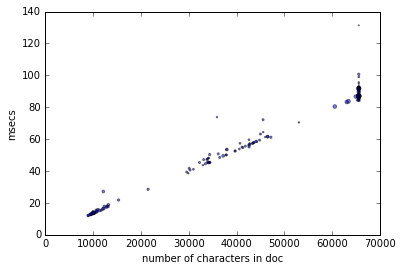

In [15]:
#Plot
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(lengths, timings, s=nattribs, alpha=0.5)
plt.xlabel('number of characters in doc')
plt.ylabel('msecs')
plt.show()

In [16]:
#Linear performance with some outliers in the longer documents (~1.25 msec per 1k characters)